In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np

from pyspark.sql import SparkSession
from pyspark.sql import types
from pyspark.sql import functions

from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import PCA
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import IDF

In [2]:
# Read in data 
with open("pickles/neurips_parsed_papers_pd.pickle", "rb") as pickleFile:
    description, neurips_pd = pickle.load(pickleFile)
with open("pickles/icml_parsed_papers_pd.pickle", "rb") as pickleFile:
    description, icml_pd = pickle.load(pickleFile)
with open("pickles/ijcai_parsed_papers_pd.pickle", "rb") as pickleFile:
    description, ijcai_pd = pickle.load(pickleFile)

In [3]:
neurips_pd["conference"] = "NeurIPS"
icml_pd["conference"] = "ICML"
ijcai_pd["conference"] = "IJCAI"

all_pd = pd.concat([neurips_pd, icml_pd, ijcai_pd])
all_pd["year"] = [int(year) for year in all_pd["year"]]

In [4]:
averages_pd = all_pd.groupby(["conference", "year"]).mean()
averages_pd.reset_index(inplace=True)
averages_pd["year"] = [int(year) for year in averages_pd["year"]]

Text(0.5, 0, 'Year')

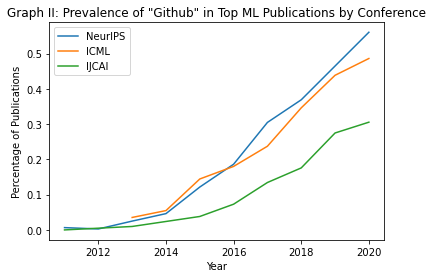

In [5]:
ax = plt.subplot()
conferences = ["NeurIPS", "ICML", "IJCAI"]
for conf in conferences:
    averages_pd[[conference == conf for conference in averages_pd["conference"]]].plot(x="year",\
                                                                                           y="Github",\
                                                                                           label=conf,\
                                                                                           ax=ax)
ax.set_title("Graph II: Prevalence of \"Github\" in Top ML Publications by Conference")
ax.set_ylabel("Percentage of Publications")
ax.set_xlabel("Year")

Text(0.5, 0, 'Year')

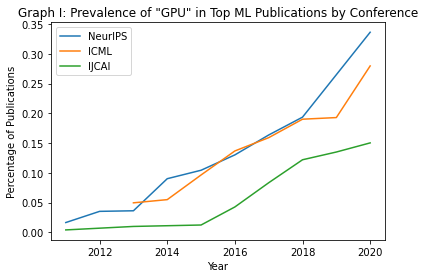

In [6]:
ax = plt.subplot()
conferences = ["NeurIPS", "ICML", "IJCAI"]
for conf in conferences:
    averages_pd[[conference == conf for conference in averages_pd["conference"]]].plot(x="year",\
                                                                                           y="GPU",\
                                                                                           label=conf,\
                                                                                           ax=ax)
ax.set_title("Graph I: Prevalence of \"GPU\" in Top ML Publications by Conference")
ax.set_ylabel("Percentage of Publications")
ax.set_xlabel("Year")

# Token Analysis

In [7]:
spark = SparkSession \
    .builder \
    .appName("Titles") \
    .config("spark.driver.memory", "3g") \
    .config("spark.executor.extraJavaOptions", "-Xss10m") \
    .getOrCreate()
sc = spark.sparkContext

In [8]:
schema = types.StructType([
    types.StructField("title", types.StringType()),
    types.StructField("year", types.IntegerType()),
    types.StructField("Github", types.IntegerType()),
    types.StructField("GPU", types.IntegerType()),
    types.StructField("Reproducibility", types.IntegerType()),
    types.StructField("Broader Impact", types.IntegerType()),
    types.StructField("Conference", types.StringType())
])
titles_df = spark.createDataFrame(all_pd, schema)

In [9]:
stopWords = []
with open("stopwords_english.txt", "r") as stopWordsFile:
    stopWords = stopWordsFile.read().split("\n")

tokenizer = Tokenizer(inputCol="title", outputCol="tokens")
title_tokenized = tokenizer.transform(titles_df)
    
remover = StopWordsRemover(inputCol="tokens", outputCol="words", stopWords=stopWords)
title_stop_removed = remover.transform(title_tokenized)

cv = CountVectorizer(inputCol="words", outputCol="raw_counts", minDF=50)
cv_model = cv.fit(title_stop_removed)
title_raw_counts = cv_model.transform(title_stop_removed)
vocab = np.array(cv_model.vocabulary)

In [10]:
title_pd = title_raw_counts.toPandas()
title_pd["raw_counts"] = [counts.toArray() for counts in title_pd["raw_counts"]]

In [11]:
withgpu_pd = title_pd[title_pd["GPU"] == 1]
nogpu_pd = title_pd[title_pd["GPU"] == 0]

In [12]:
withgpu_avg = np.mean(withgpu_pd["raw_counts"])
nogpu_avg = np.mean(nogpu_pd["raw_counts"])
difference = withgpu_avg - nogpu_avg
difference_pd = pd.DataFrame({"Without GPU": nogpu_avg,\
                              "With GPU": withgpu_avg,\
                              "Difference": difference},\
                             index = vocab)

In [13]:
difference_pd.loc[list(vocab[np.argsort(difference)[::-1][:10]])]

,Without GPU,With GPU,Difference
neural,0.051860,0.174753,0.122894
deep,0.046377,0.150708,0.104331
networks,0.058009,0.152426,0.094417
learning,0.212105,0.260198,0.048092
convolutional,0.008668,0.045942,0.037275
network,0.025337,0.061829,0.036492
training,0.010816,0.042937,0.032120
image,0.011187,0.032632,0.021445
adversarial,0.021633,0.042508,0.020875
graph,0.020744,0.039931,0.019187


In [14]:
difference_pd.loc[list(vocab[np.argsort(difference)[:10]])]

,Without GPU,With GPU,Difference
,0.055119,0.010305,-0.044814
online,0.026893,0.007729,-0.019164
algorithms,0.021262,0.006011,-0.015251
analysis,0.024522,0.012452,-0.012070
bounds,0.012891,0.001717,-0.011173
algorithm,0.016669,0.005582,-0.011087
clustering,0.018447,0.007729,-0.010719
bandits,0.012594,0.002576,-0.010018
matrix,0.016447,0.006441,-0.010006
selection,0.014298,0.004294,-0.010005


In [142]:
a = np.array(list(range(20)))
a[:2]

array([0, 1])

In [21]:
all_pd[all_pd["GPU"] == 1]

,title,year,Github,GPU,Reproducibility,Broader Impact,conference
0,A graph similarity for deep learning,2020,1,1,1,1,NeurIPS
1,An Unsupervised Information-Theoretic Perceptu...,2020,1,1,0,1,NeurIPS
2,Self-Supervised MultiModal Versatile Networks,2020,1,1,0,1,NeurIPS
3,"Benchmarking Deep Inverse Models over time, an...",2020,1,1,0,1,NeurIPS
5,Neural Methods for Point-wise Dependency Estim...,2020,1,1,1,1,NeurIPS
...,...,...,...,...,...,...,...
5171,User-Centered Programming by Demonstration: St...,2013,0,1,0,0,IJCAI
5172,Scalable Dynamic Nonparametric Bayesian Models...,2013,0,1,0,0,IJCAI
5212,Object Recognition Based on Visual Grammars an...,2013,0,1,0,0,IJCAI
5427,"Flexible, High Performance Convolutional Neura...",2011,0,1,0,0,IJCAI
